In [108]:
%pip install elephant quantities neo xarray numpy matplotlib scipy pathlib pyocclient netCDF4

Note: you may need to restart the kernel to use updated packages.


### Utility functions

Run the cell below, but feel free to ignore this code — it’s just some utility functions we’ll use later for convenience.

In [109]:
import numpy as np
import neo
import quantities as pq
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
from elephant.current_source_density import estimate_csd


def add_um_units(channels_depth_vals):
    """Add units to coordinates of channels on probe"""
    return np.array([np.abs(channels_depth_vals)]).T*pq.um

def create_neo_lfp(lfp_values, sampling_frequency):
    """Put lfp data in time window in neo format"""
    return neo.AnalogSignal(
        lfp_values.values.T,    # The lfp must be transposed to have time on the first dimension for neo
        units=pq.V, 
        sampling_rate=sampling_frequency*pq.Hz
    )

def get_data_time_window(data, time, time_window_start, time_window_end, is_trial_avg = True):
    """Get lfp or csd data in selected time window"""
    mask_time_window = (time > time_window_start) & (time < time_window_end)

    # get data in time window
    if is_trial_avg:
        data_window = data[:, mask_time_window]
    else:
        data_window = data[:, :, mask_time_window]

    return data_window

def correlate_pairwise_trials(csd):
    '''Correlate csd from all trials pairwise'''
    corr_csd_all_trials = []

    for itrialA in range(csd.shape[1]):
        corr_csd_temp = []
        for itrialB in range(csd.shape[1]):
            corr_csd_temp.append(pearsonr(csd[:,itrialA].flatten(), csd[:,itrialB].flatten())[0])
        corr_csd_all_trials.append(corr_csd_temp)

    return np.array(corr_csd_all_trials)

def euclidian_norm_pairwise_trials(csd):
    '''Correlate csd from all trials pairwise'''
    eucnorm_csd_all_trials = []

    for itrialA in range(csd.shape[1]):
        eucnorm_csd_temp = []
        for itrialB in range(csd.shape[1]):
            eucnorm_csd_temp.append(np.linalg.norm(csd[:,itrialA]-csd[:,itrialB]))
        eucnorm_csd_all_trials.append(eucnorm_csd_temp)

    return np.array(eucnorm_csd_all_trials)


def plot_csd(csd):
    plt.figure(figsize=(5,4))
    plt.imshow(
        np.array(csd.T),                          # The csd must be transposed to get channels on first dimension for the plot
        aspect = 'auto', 
        cmap = 'RdBu_r',  # 
        norm=TwoSlopeNorm(vcenter=0),
    )  # Puts white a the zero value, so blue is always negative and red is always positive
    plt.ylabel('Channel nr.')
    plt.colorbar();


def calc_csd(lfp, sampling_freq, channel_depths, method='StandardCSD', **csd_kwargs) -> 'neo':
    lfp_neo = create_neo_lfp(lfp, sampling_frequency=sampling_freq) # The lfp must be transposed to have time on the first dimension for neo
    coords = add_um_units(channels_depth_vals=channel_depths.values)  # create array with channel positions and units
    csd_neo = estimate_csd(lfp_neo, coordinates=coords, method=method, **csd_kwargs)
    return csd_neo

class utils:
    correlate_pairwise_trials = correlate_pairwise_trials
    euclidian_norm_pairwise_trials = euclidian_norm_pairwise_trials
    calc_csd = calc_csd
    plot_csd = plot_csd

## Download dataset

In [110]:
import owncloud
import os

if not os.path.exists('../../data'):
    print('Creating directory for data')
    os.mkdir('../../data')

if not os.path.exists('../../data/dataset_session_754312389.nc'):
    print('Downloading data')
    owncloud.Client.from_public_link('https://uni-bonn.sciebo.de/s/ZAs9uJ1KzrWi0ra').get_file('/', '../../data/dataset_session_754312389.nc')
else:
    print('Dataset already downloaded')

Dataset already downloaded


### Load dataset

Run the cell below to load dataset and extract LFP data.

In [111]:
import xarray as xr
from pathlib import Path

loadpath = '../../data/dataset_session_754312389.nc'
dataset_path = Path(loadpath)

dataset = xr.load_dataset(dataset_path)
dataset = dataset[[
    'lfp_trials',
    'csd_trials'
]]
dataset

<xarray.Dataset> Size: 52MB
Dimensions:                       (channel_depth: 23, trial_stimulus_id: 75,
                                   time_from_stimulus_onset_lfp: 1875,
                                   time_from_stimulus_onset_csd: 1875)
Coordinates:
  * channel_depth                 (channel_depth) int64 184B 0 -40 ... -840 -880
  * trial_stimulus_id             (trial_stimulus_id) int32 300B 3649 ... 3796
  * time_from_stimulus_onset_lfp  (time_from_stimulus_onset_lfp) float64 15kB ...
  * time_from_stimulus_onset_csd  (time_from_stimulus_onset_csd) float64 15kB ...
Data variables:
    lfp_trials                    (channel_depth, trial_stimulus_id, time_from_stimulus_onset_lfp) float64 26MB ...
    csd_trials                    (channel_depth, trial_stimulus_id, time_from_stimulus_onset_csd) float64 26MB ...
Attributes:
    time_unit:                  millisecond
    lfp_unit:                   Volt
    channel_depth_unit:         micrometer
    note_channel_depth:         Measured in distance from electrode closest t...
    sampling_frequency_lfp:     1250
    sampling_frequency_spikes:  1000
    sampling_frequency_unit:    Hz

# Introduction

The LFP can be challenging to interpret in terms of the underlying neurophysiology. One method that helps make the LFP more interpretable is current source density (CSD) analysis. The CSD is calculated from the LFP and shows where the current sinks and sources generating the LFP are located in space and when they arise. A current sink shows where positive ions *enter* a neuron/population of neurons, while a current source shows where positive ions *leave* a neuron/population of neurons.

When a neuron receives excitatory input, positive ions flush into the neuron at the synapse. This will show up as a current sink in a CSD plot. Therefore, a current sink can tell you where and when a population of neurons gets input. There are multiple different neuronal processes that can give rise to a current sink or a current source, so the interpretation is still not always straightforward, but the CSD at least brings us one step closer to interpreting the electrical signals we record in terms of the neurophysiology.

## Section 1: Calculate the current source density (CSD) from the recorded LFP using the "standard" method.

In this section, you will learn how to calculate the CSD from the LFP using the `estimate_csd` function from the `elephant` library with the so-called standard method.

| Code | Description |
| :-- | :-- |
| `utils.calc_csd(lfp, sampling_freq, channel_depths)` | calculates a CSD and returns a Neo AnalogSignal |
| `pq.um` | Defines the quantities unit micrometer. |
| `gaussian_filter(data, sigma = (filter_width_1st_dim, filter_width_2nd_dim))` | Apply a 2D gaussian filter to smooth data. `sigma =  (filter_width_1st_dim, filter_width_2nd_dim)` sets the width of the filter along each axis of the data.|

**Example**: Calculate and plot the CSD for the first trial (trial index 0).

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


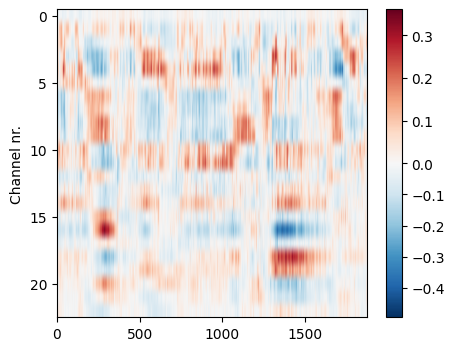

In [112]:
lfp = dataset['lfp_trials'][:, 0]
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='StandardCSD')
utils.plot_csd(csd)

**Exercise**: Calculate and plot the CSD for trial at index 30.

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


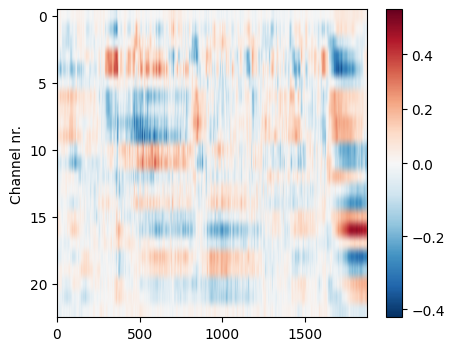

In [113]:
lfp = dataset['lfp_trials'][:, 30]
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='StandardCSD')
utils.plot_csd(csd)

**Exercise**: Calculate and plot the CSD for the trial averaged LFP  (Tip: `data.mean(dim='trial_stimulus_id')`)

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


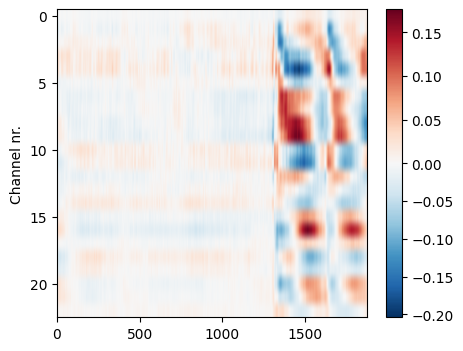

In [114]:
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='StandardCSD')
utils.plot_csd(csd)

**Example**: Using the `gaussian_filter()` function, smooth the CSD from across depth (over the channels) with a gaussian filter with ``sigma = (1,0)``. (The 0 means that no smoothing is across over the time dimension.) Plot the CSD after smoothing with the `pcolormesh` function.

In [115]:
from scipy.ndimage import gaussian_filter

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


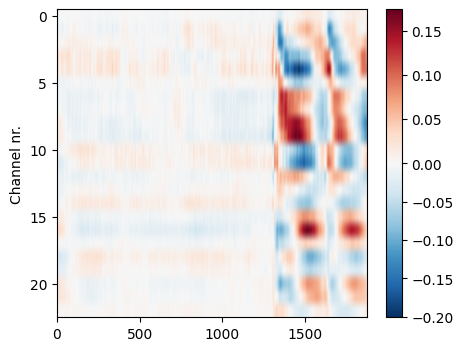

In [116]:
# provided
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth)

csd_smoothed = gaussian_filter(csd, sigma=(1, 0))
utils.plot_csd(csd_smoothed)

**Exercise**: Smooth the CSD across depth (over the channels) with a gaussian filter with ``sigma = (4,0)``. Plot the CSD after smoothing. 

What happened to the minor and the major sinks and sources in the plot when you compare to CSD plots with no or less smoothing?

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


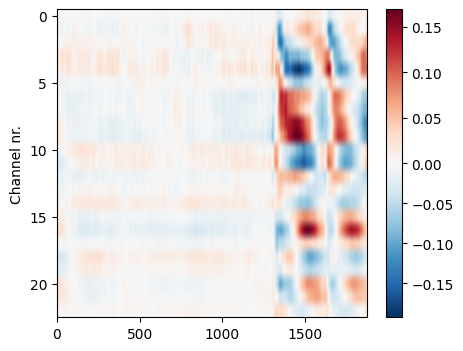

In [117]:
# solution
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth)

csd_smoothed = gaussian_filter(csd, sigma=(4, 0))
utils.plot_csd(csd_smoothed)

**Exercise**: Smooth the CSD across time with a gaussian filter with ``sigma = (0,4)``. Plot the CSD after smoothing.

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


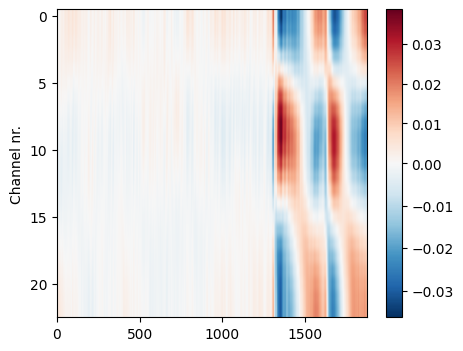

In [118]:
# solution
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth)

csd_smoothed = gaussian_filter(csd, sigma=(0, 4))
utils.plot_csd(csd_smoothed)

**Exercise**: Smooth the CSD across depth and time with a gaussian filter with ``sigma = (2,2)``. Plot the CSD after smoothing.

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


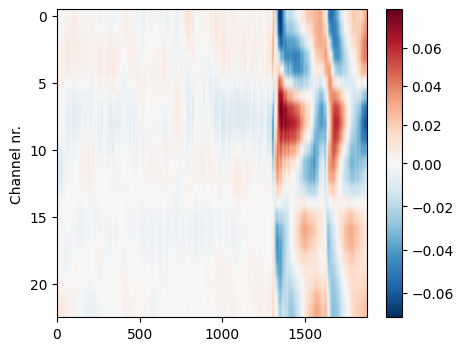

In [119]:
# solution
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth)

csd_smoothed = gaussian_filter(csd, sigma=(2, 2))

utils.plot_csd(csd_smoothed)

Comment: While smoothing and interpolation can improve your visalization by making your plots more readable, excessive smoothing can make them misleading, so use with care.

## Section 2: Slicing Time Points and Plotting Time and Making 2D plots using `plt.pcolormesh()`


| Code | Description |
| :-- | :-- |
|`mask = dataset['time_from_stimulus_onset_lfp'] > 0`  | Create a logical mask |
| `subdata = dataset.where(mask, drop=True)` | Use the mask to extract data | 
| `plt.pcolormesh(x, y, C, cmap = 'plasma', shading = 'gouraud')` | Make a 2D colormap of values in a 2D array (C) against x and y values. The optional parameters ``cmap`` and `shading` defines the colormap and the interpolation applied to the plot, respectively. |

**Example:** Extract and plot the CSD calculated from the trial averaged LFP from stimulus onset to the end of the trial. 

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


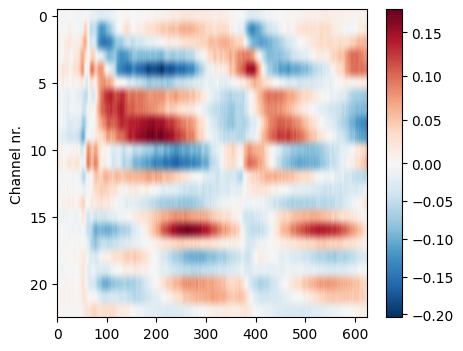

In [120]:
# provided
mask = dataset.time_from_stimulus_onset_lfp > 0
lfp = dataset['lfp_trials'].where(mask, drop=True).mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='StandardCSD')
utils.plot_csd(csd)

Extract and plot the CSD calculated from the trial averaged LFP from the beginning of the trial to the stimulus onset.


discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


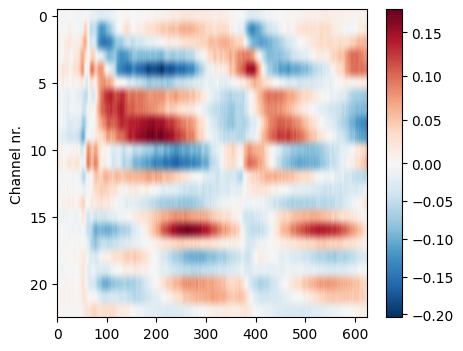

In [121]:
mask = 0 < dataset.time_from_stimulus_onset_lfp
lfp = dataset['lfp_trials'].where(mask, drop=True).mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='StandardCSD')
utils.plot_csd(csd)

**Exercise**: Extract and plot the CSD from 200 msec before stimulus onset until 100 ms after stimulus onset. 

Approximately when does the first current sink (blue blob) arise? Is the position of this blob between channels 5 and 10 - roughly layer 4 of the primary visual cortex? If so, the CSD plot is correct.

Useful Code:
```python
mask = (0 < dataset['time_from_stimulus_onset_lfp']) & (dataset['time_from_stimulus_onset_lfp'] < 500)
```

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


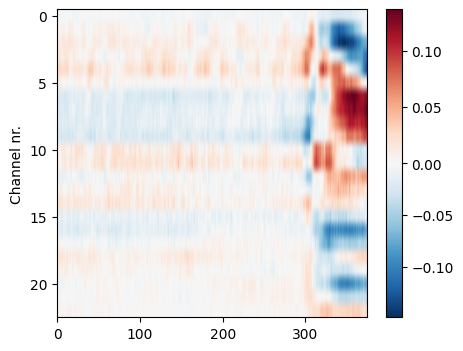

In [122]:
mask = (-200 < dataset.time_from_stimulus_onset_lfp) & (dataset.time_from_stimulus_onset_lfp < 100)
lfp = dataset['lfp_trials'].where(mask, drop=True).mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth)
utils.plot_csd(csd)

**Example**: Plot the trial averaged CSD in the first 100 ms after stimulus onset using ``plt.pcolormesh`` function. Pass the time points that the LFP was sampled as the first parameter and the depth of channels (`channels_depth`) as the second parameter to the `pcolormesh` function.

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


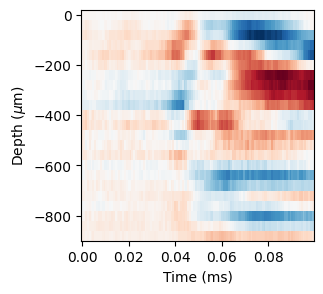

In [123]:
mask = (0 < dataset.time_from_stimulus_onset_lfp) & (dataset.time_from_stimulus_onset_lfp < 100)
lfp = dataset['lfp_trials'].where(mask, drop=True).mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth)

plt.figure(figsize=(3,3))
plt.pcolormesh(csd.times, dataset.channel_depth, csd.T, cmap = 'RdBu_r')
plt.xlabel('Time (ms)')
plt.ylabel(r'Depth ($\mu$m)');

**Example**: Plot the trial averaged CSD in the first 250 ms after stimulus onset using ``plt.pcolormesh`` function. Pass the time points that the LFP was sampled as the first parameter and the depth of channels (`channels_depth`) as the second parameter to the `pcolormesh` function.

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


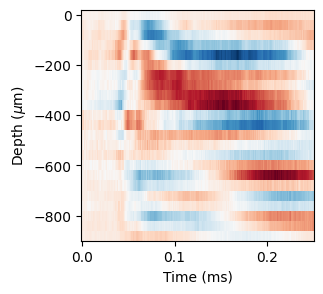

In [124]:
# provided
mask = (0 < dataset.time_from_stimulus_onset_lfp) & (dataset.time_from_stimulus_onset_lfp < 250)
lfp = dataset['lfp_trials'].where(mask, drop=True).mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth)

plt.figure(figsize=(3,3))
plt.pcolormesh(csd.times, dataset.channel_depth, csd.T, cmap = 'RdBu_r')
plt.xlabel('Time (ms)')
plt.ylabel(r'Depth ($\mu$m)');

Get the CSD from the from 200 ms before stimulus onset to 200 ms after stimulus onset and plot it using ``plt.pcolormesh`` function. Pass the time points that the LFP was sampled as the first parameter and the depth of channels (`channels_depth`) as the second parameter to the `pcolormesh` function.

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


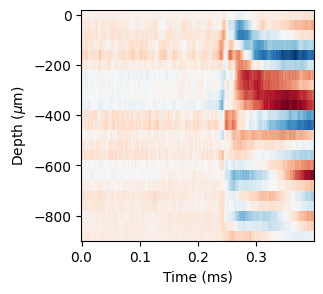

In [125]:
# solution
mask = (-200 < dataset.time_from_stimulus_onset_lfp) & (dataset.time_from_stimulus_onset_lfp < 200)
lfp = dataset['lfp_trials'].where(mask, drop=True).mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth)

plt.figure(figsize=(3,3))
plt.pcolormesh(csd.times, dataset.channel_depth, csd.T, cmap = 'RdBu_r')
plt.xlabel('Time (ms)')
plt.ylabel(r'Depth ($\mu$m)');

## Section 3: Calculate the current source density (CSD) from the recorded LFP using the delta source method.

The method you used above to compute the CSD is called the "standard" method simply because it was developed first. The standard method assumes that the CSD is infinitely constant lateral to the probe, which does not always hold true. Sometimes, this approximation is good enough to not cause any major errors in the CSD estimate, but in other cases it can result in an incorrect CSD amplitude and to spurious current sinks and sources in the estimate.

One alternative method that has been developed to deal with this issue is called the "delta source" method, which only assumes that the CSD is constant within a certain diameter lateral to the probe. In this section, you will explore the calculation of CSD using the delta source method.

| Code | Description |
| :-- | :-- |
| `neo.AnalogSignal(lfp_data.values.T,units=pq.V,`<br> &nbsp;&nbsp;&nbsp;&nbsp;`sampling_frequency_lfp*pq.Hz)` | Make an LFP neo object containing LFP data. `units` specifies the physical unit of the object - `pq.V` means Volt.|
| `plt.imshow(data, aspect = 'auto',` <br> &nbsp;&nbsp;&nbsp;&nbsp; `cmap = 'selected_colormap')` | Plots a multidimensional array as an image. `aspect` sets the aspect ratio of the axis. `cmap` sets the colormap.|
| `plt.colorbar()` | Add a colorbar to the plot.|
| `estimate_csd(lfp_neo, coords,`<br> &nbsp;&nbsp;&nbsp;&nbsp;`method='StandardCSD')` | Calculate the CSD from the LFP using the standard method.|
| `estimate_csd(lfp_neo, coords,` <br> &nbsp;&nbsp;&nbsp;&nbsp; `method='DeltaiCSD', diam = some_diam*pq.um)` | Calculate the CSD from the LFP using the ``DeltaiCSD`` method. A parameter `diam` must be passed which defines the diameter lateral to probe where CSD is assumed constant. |
| `data.T` | Transposes an array from N x M to M x N. For example, if channels is on the first dimension and time is on the second, data.T would transpose it so that time is on the first dimension and channels on the second. |


**Example**: Calculate and plot the CSD for the trial averaged LFP using **Delta iCSD** method rather than the standard method. 

Change the ``method`` parameter in the ``estimate_csd`` function. Set the `diam` parameter to ``800*pq.um``.

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


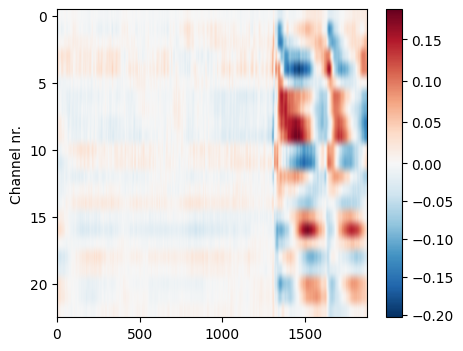

In [126]:
diameter = 800*pq.um
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='DeltaiCSD', diam=diameter)
utils.plot_csd(csd)

**Exercise**: Change the diameter parameter to 200 $\mu m$ and calculate and plot the the CSD again. What changed?

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


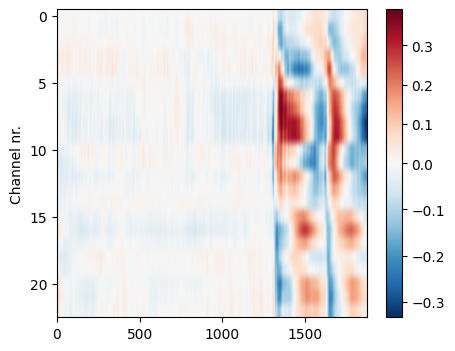

In [127]:
# solution
diameter = 200*pq.um
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='DeltaiCSD', diam=diameter)
utils.plot_csd(csd)

**Exercise**: Change the diameter parameter to 1600 $\mu m$ and calculate and plot the the CSD again. What changed?

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


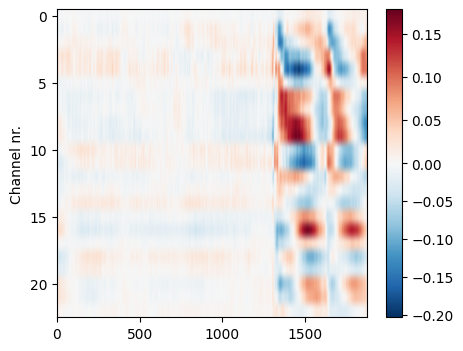

In [128]:
# solution
diameter = 1600*pq.um
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='DeltaiCSD', diam=diameter)
utils.plot_csd(csd)

**Exercise**: Calculate the CSD with the **standard method** (`method='StandardCSD'`)and plot it again. 

Which of the three plots above (where the CSD was calculated with the delta method with different diameters) does this CSD plot resemble the most? Is it the plot you would expect, considering the diameter used with the delta method in that plot?

discrete filter coefficients: 
b = [ 0.607 1.000 0.607 ],                
a = [ 2.213 ]


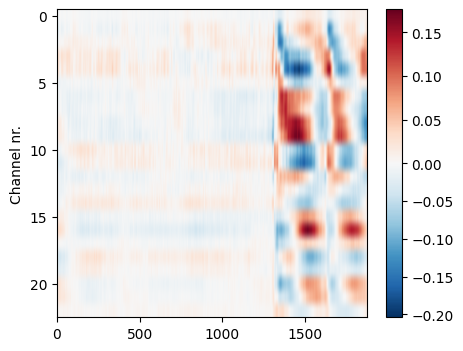

In [129]:
# solution
lfp = dataset['lfp_trials'].mean(dim='trial_stimulus_id')
csd = utils.calc_csd(lfp, dataset.sampling_frequency_lfp, dataset.channel_depth, method='StandardCSD')
utils.plot_csd(csd)

**Comment**: As you saw above, the diameter parameter you set for the delta method will affect the amplitude and the distribution of sinks and sources in the CSD estimate. Usually, one can't know what exactly the correct diameter is. You have to settle for a reasonable estimate based on the physiology of the structure in question. For the cortex, a reasonable value to use is the diameter of a cortical column, which is approximately 300-500 micrometer in mice.

## Section 4: Metrics to quantify CSD similarity: Correlation, euclidian distance, and Wasserstein distance.

Sometimes you want to compare the CSD from different trials or different animals. Visualization is a great way to do that, but you may need to quantify the level of similarity between CSD plots too. Below are a few methods that can be used for that.

| Code | Description |
| :-- | :-- |
| ``data.flatten()`` | Flattens a multidimensional array into a vector |
| `pearsonr(array_1.flatten(), array2.flatten())` | Calculates the Pearson correlation between two vectors. |
| `plt.scatter(x, y)` | Make a scatter plot.  |
| `np.linalg.norm(array_1 - array2)` | Calculates the eucledian distance between two arrays. |
| `wasserstein_distance(array_1.flatten(), array2.flatten())` | Calculates the Wasserstein distance (WD) (also called the earth mover distance) between two (flattened) arrays. The smaller the Wasserstein distance is, the more similar the arrays are. |
| `utils.correlate_pairwise_trials(csd)` | Calculate pairwise correlation between csd from all trials. |
| `utils.euclidian_norm_pairwise_trials(csd)` | Calculate the pairwise euclidian distance between csd from all trials. |




In [130]:
from scipy.stats import wasserstein_distance, pearsonr

Run the cell below to get pre-calculated CSD from all trials and select the CSD from the first 100 ms after stimulus onset.

In [131]:
time_window_start = 0 # at stimulus onset
time_window_end = 100

# load precomputed csd in all trials form dataset
csd_trials = dataset['csd_trials']
time_from_stimulus_onset_csd = csd_trials.time_from_stimulus_onset_csd
mask_time_window = np.logical_and(time_window_start < time_from_stimulus_onset_csd, 
                                  time_window_end > time_from_stimulus_onset_csd)

csd_trials = csd_trials.values[:,:,mask_time_window]
csd_trials.shape


(23, 75, 125)

**Example**: Calculate the correlation between the CSD from trial 20 and trial 21.

PearsonRResult(statistic=0.6614942496566332, pvalue=0.0)

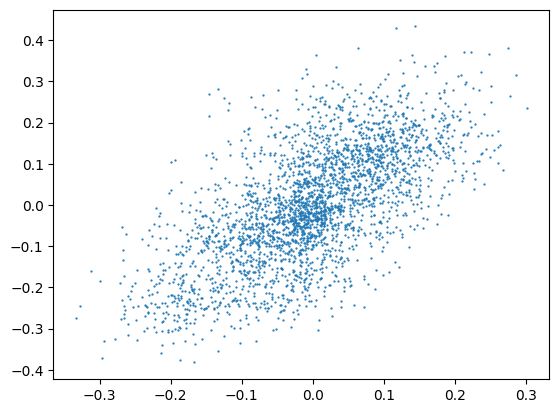

In [132]:
# provided
csd_trialA = csd_trials[:, 20].flatten()
csd_trialB = csd_trials[:,21].flatten()

plt.scatter(csd_trialA, csd_trialB, marker='.', s=1.5);
pearsonr(csd_trialA, csd_trialB)

**Exercise**: Calculate the correlation between the CSD from trial 0 and the last trial (set ``itrialB`` to ``74`` or ``-1``).

Are these trials more or less similar than the neighboring trials in the previous exercise?

PearsonRResult(statistic=0.10428248676854074, pvalue=2.0900224966658597e-08)

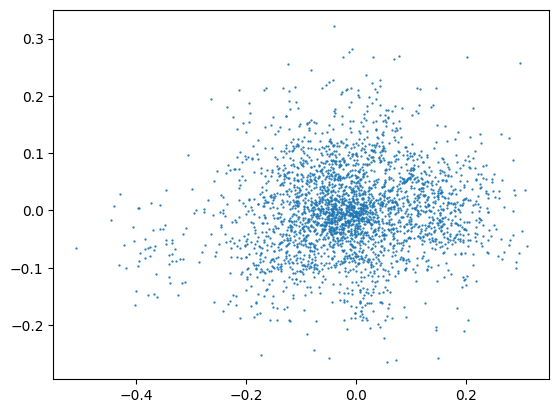

In [133]:
# solution
csd_trialA = csd_trials[:, 0].flatten()
csd_trialB = csd_trials[:,-1].flatten()

plt.scatter(csd_trialA, csd_trialB, marker='.', s=1.5);
pearsonr(csd_trialA, csd_trialB)

**Exercise**: Calculate the correlation between the CSD from the first trial and the trial averaged CSD.

PearsonRResult(statistic=0.24234596134818903, pvalue=1.060098462351822e-39)

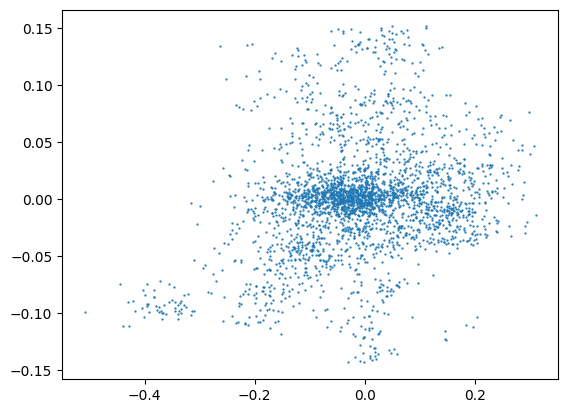

In [134]:
# solution
csd_trialA = csd_trials[:, 0].flatten()
csd_trialB = csd_trials.mean(axis=1).flatten()

plt.scatter(csd_trialA, csd_trialB, marker='.', s=1.5);
pearsonr(csd_trialA, csd_trialB)

**Demo**: Run the cell below to calculate and plot the pairwise correlation between the CSD from all trials.

Does this plot suggest that neighboring trials are typically more correlated?

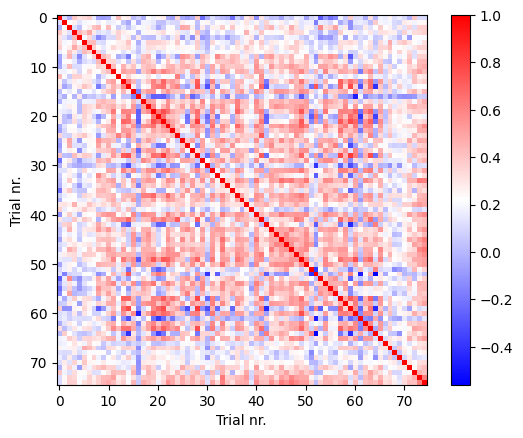

In [135]:
corr_csd_all_trials = utils.correlate_pairwise_trials(csd_trials)

plt.imshow(corr_csd_all_trials, cmap = 'bwr')
plt.xlabel('Trial nr.')
plt.ylabel('Trial nr.')
plt.colorbar();

**Exercise**: Calculate the euclidian distance between the CSD from the first and the second trial.

In [136]:
# solution

**Exercise**: Calculate the euclidian distance between the CSD from trial 0 and the last trial.

In [137]:
# solution


**Exercise**: Calculate and plot the pairwise euclidian distance between the the CSD from all trials.

An important difference between the euclidian distance and the correlation is that amplitude differences also matters for the euclidian distance, so this plot will not necessarily have the same structure as the correlation plot above.

In [138]:
# solution


**Exercise**: Calculate the Wasserstein distance between the CSD from the first and the second trial.

In [139]:
# solution


**Exercise**: Calculate the Wasserstein distance between the CSD from the first and the last trial.

In [140]:
# solution


**Discussion Exercise**:
- What are some potential reasons for using one or another metric to quantify similarity between two CSD plots?